In [1]:
%load_ext autoreload
%autoreload 2

In [120]:
import slippi
from slippi import Game
import pickle
import pandas as pd
import glob
import numpy as np
from tqdm import tqdm 

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import log_loss,accuracy_score
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier

from ipywidgets import interact

pd.set_option('display.max_columns', None)


import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

from data_utils import construct_df, ohe_chars_stage, characters, stages
from modeling_utils import plot_log_loss, plot_multiple_log_loss, CV_model, plot_feature_importances,\
                            plot_win_probs, get_log_losses, validate_model

import xgboost as xgb

## Import and split data 

In [4]:
gs_5s_ohe=pd.read_pickle('saved_data/gs_5s_ohe.pkl')
fp9_5s_ohe=pd.read_pickle('saved_data/fp9_5s_ohe.pkl')
p2019_5s_ohe=pd.read_pickle('saved_data/p2019_5s_ohe.pkl')

In [5]:
fp9_5s_ohe=fp9_5s_ohe[fp9_5s_ohe['frames_elapsed']%300 == 0]
fp9_5s_ohe=fp9_5s_ohe[fp9_5s_ohe['frames_elapsed']%300 == 0]
fp9_5s_ohe.to_pickle('saved_data/fp9_5s_ohe.pkl')

gs_5s_ohe=gs_5s_ohe[gs_5s_ohe['frames_elapsed']%300 == 0]
gs_5s_ohe=gs_5s_ohe[gs_5s_ohe['frames_elapsed']%300 == 0]
gs_5s_ohe.to_pickle('saved_data/gs_5s_ohe.pkl')

In [129]:
df = pd.concat([gs_5s_ohe, fp9_5s_ohe,p2019_5s_ohe]).reset_index(drop=True)
#df = gs_5s_ohe.copy()
df

,id,p1_char,p2_char,stage,frames_elapsed,p1_stocks,p2_stocks,p1_damage,p2_damage,winner,p1_FOX,p1_FALCO,p1_MARTH,p1_SHEIK,p1_JIGGLYPUFF,p1_PEACH,p1_ICE_CLIMBERS,p1_CAPTAIN_FALCON,p1_PIKACHU,p1_SAMUS,p1_DR_MARIO,p1_YOSHI,p1_LUIGI,p1_GANONDORF,p1_MARIO,p1_YOUNG_LINK,p1_DONKEY_KONG,p1_LINK,p1_GAME_AND_WATCH,p1_ROY,p1_MEWTWO,p1_ZELDA,p1_NESS,p1_PICHU,p1_BOWSER,p1_KIRBY,p2_FOX,p2_FALCO,p2_MARTH,p2_SHEIK,p2_JIGGLYPUFF,p2_PEACH,p2_ICE_CLIMBERS,p2_CAPTAIN_FALCON,p2_PIKACHU,p2_SAMUS,p2_DR_MARIO,p2_YOSHI,p2_LUIGI,p2_GANONDORF,p2_MARIO,p2_YOUNG_LINK,p2_DONKEY_KONG,p2_LINK,p2_GAME_AND_WATCH,p2_ROY,p2_MEWTWO,p2_ZELDA,p2_NESS,p2_PICHU,p2_BOWSER,p2_KIRBY,stage_BATTLEFIELD,stage_FINAL_DESTINATION,stage_DREAM_LAND_N64,stage_YOSHIS_STORY,stage_FOUNTAIN_OF_DREAMS,stage_POKEMON_STADIUM
0,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,0,4.0,4.0,0.000000,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,300,4.0,4.0,0.000000,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,600,4.0,4.0,27.440001,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,900,4.0,4.0,52.270004,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,1200,4.0,4.0,95.940002,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425371,Game_20190421T135159,FOX,FALCO,POKEMON_STADIUM,6900,1.0,2.0,0.000000,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
425372,Game_20190421T135159,FOX,FALCO,POKEMON_STADIUM,7200,1.0,2.0,20.000000,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
425373,Game_20190421T135159,FOX,FALCO,POKEMON_STADIUM,7500,1.0,2.0,60.120003,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
425374,Game_20190421T135159,FOX,FALCO,POKEMON_STADIUM,7800,1.0,2.0,60.120003,22.6,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [77]:
features = list(df.columns[4:])
features.remove('winner')

In [78]:
features

['frames_elapsed',
 'p1_stocks',
 'p2_stocks',
 'p1_damage',
 'p2_damage',
 'p1_FOX',
 'p1_FALCO',
 'p1_MARTH',
 'p1_SHEIK',
 'p1_JIGGLYPUFF',
 'p1_PEACH',
 'p1_ICE_CLIMBERS',
 'p1_CAPTAIN_FALCON',
 'p1_PIKACHU',
 'p1_SAMUS',
 'p1_DR_MARIO',
 'p1_YOSHI',
 'p1_LUIGI',
 'p1_GANONDORF',
 'p1_MARIO',
 'p1_YOUNG_LINK',
 'p1_DONKEY_KONG',
 'p1_LINK',
 'p1_GAME_AND_WATCH',
 'p1_ROY',
 'p1_MEWTWO',
 'p1_ZELDA',
 'p1_NESS',
 'p1_PICHU',
 'p1_BOWSER',
 'p1_KIRBY',
 'p2_FOX',
 'p2_FALCO',
 'p2_MARTH',
 'p2_SHEIK',
 'p2_JIGGLYPUFF',
 'p2_PEACH',
 'p2_ICE_CLIMBERS',
 'p2_CAPTAIN_FALCON',
 'p2_PIKACHU',
 'p2_SAMUS',
 'p2_DR_MARIO',
 'p2_YOSHI',
 'p2_LUIGI',
 'p2_GANONDORF',
 'p2_MARIO',
 'p2_YOUNG_LINK',
 'p2_DONKEY_KONG',
 'p2_LINK',
 'p2_GAME_AND_WATCH',
 'p2_ROY',
 'p2_MEWTWO',
 'p2_ZELDA',
 'p2_NESS',
 'p2_PICHU',
 'p2_BOWSER',
 'p2_KIRBY',
 'stage_BATTLEFIELD',
 'stage_FINAL_DESTINATION',
 'stage_DREAM_LAND_N64',
 'stage_YOSHIS_STORY',
 'stage_FOUNTAIN_OF_DREAMS',
 'stage_POKEMON_STADIUM']

In [130]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)

df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

In [131]:
X_train = df_train[features]
y_train = df_train['winner']

X_val = df_val[features]
y_val = df_val['winner']

X_test = df_test[features]
y_test = df_test['winner']




## Testing some models

Average training accuracy: 0.991
Average training log loss: 0.113
Average CV accuracy: 0.846
Average CV log loss: 0.371


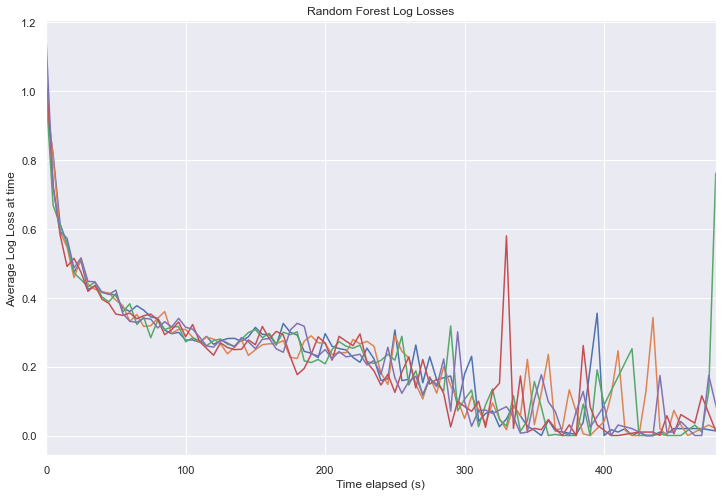

In [46]:
rf = CV_model(RandomForestClassifier(n_estimators =100, n_jobs=-1), X_train, y_train, 'Random Forest Log Losses')

Training accuracy: 0.986
Training log loss: 0.130
Validation accuracy: 0.801
Validation log loss: 0.426


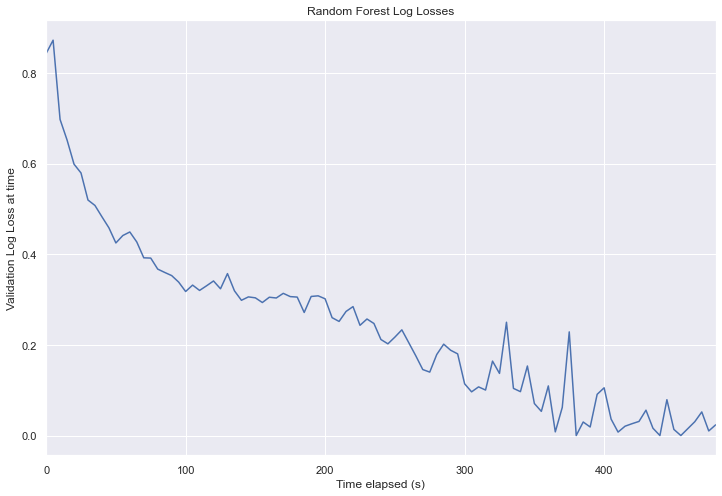

In [132]:
rf = validate_model(RandomForestClassifier(n_estimators =100, n_jobs=-1),
                    X_train, y_train,X_val,y_val, 'Random Forest Log Losses')

Training accuracy: 0.986
Training log loss: 0.130
Validation accuracy: 0.801
Validation log loss: 0.418


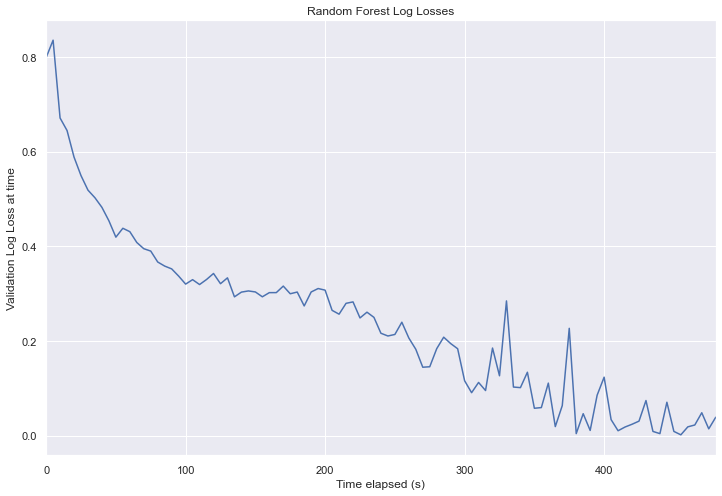

In [137]:
rf = validate_model(RandomForestClassifier(n_estimators =500, n_jobs=-1, max_features=8),
                    X_train, y_train,X_val,y_val, 'Random Forest Log Losses')

In [118]:
nc_feats =features[:5] + features[-6:]

Random forest works pretty well all things considered, log loss mostly goes down over time. Does get noisy at the very end of the game, which makes sense since things can get weird then, especially with timeouts. Hopefully that can go down with more data

Average training accuracy: 0.751
Average training log loss: 0.491
Average CV accuracy: 0.750
Average CV log loss: 0.491


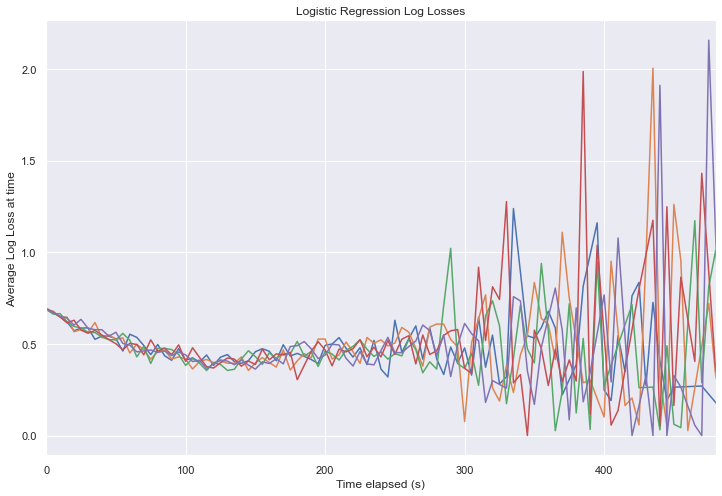

In [47]:
lr=CV_model(LogisticRegression(max_iter=5000), X_train, y_train, 'Logistic Regression Log Losses')

Logistic regression looks worse than RF - LL doesn't decrease as much and is noisier at the end

Average training accuracy: 0.539
Average training log loss: 1.197
Average CV accuracy: 0.538
Average CV log loss: 1.201


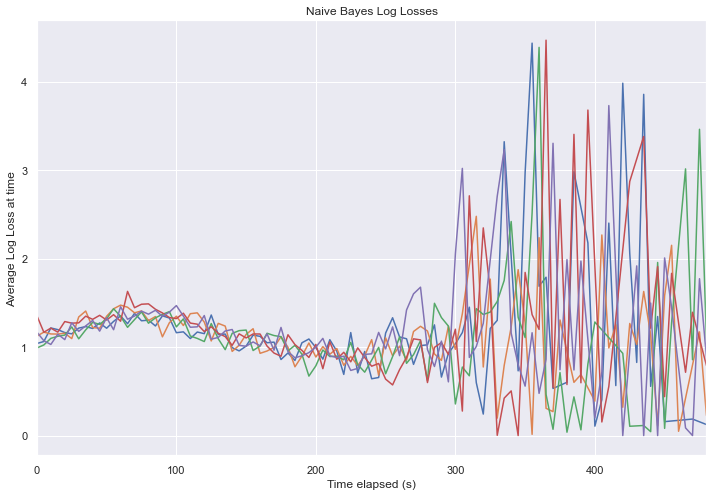

In [48]:
nb=CV_model(GaussianNB(), X_train, y_train, 'Naive Bayes Log Losses')

NB doesn't look good, not a huge surprise

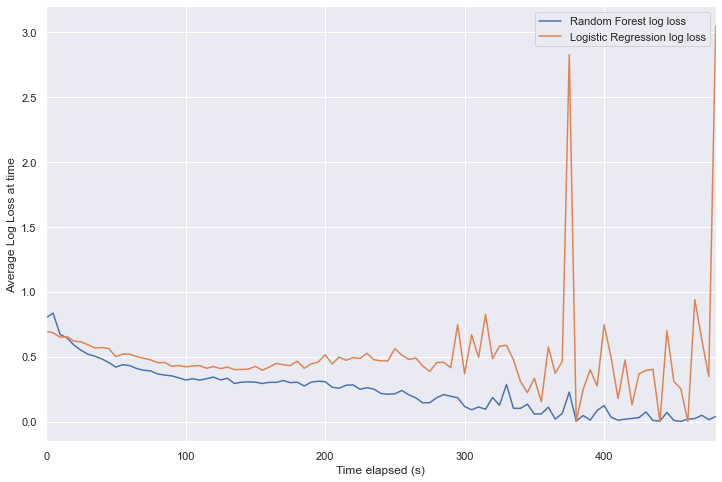

In [138]:
plot_multiple_log_loss(X_val, y_val, [rf,lr], ['Random Forest','Logistic Regression'])

### Random Forest model details 

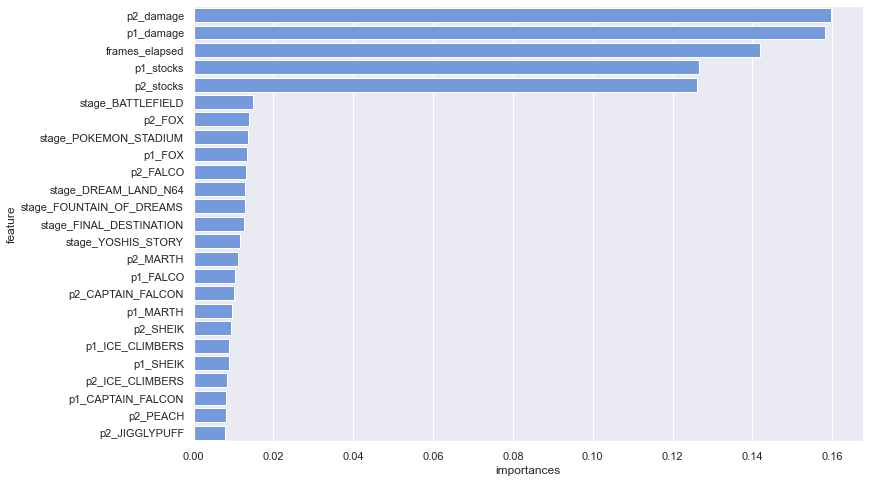

In [69]:
plot_feature_importances(rf, features, 25)

Feature importances are in line with what we expect - damage, time, and stocks are the biggest factors. Then stages and top tiers.

In [51]:
mango_axe_game = construct_df(['replays/mangoaxe.slp'],1)
mango_axe_game = ohe_chars_stage(mango_axe_game)

mango_zain_game = construct_df(['replays/mangozain.slp'],1)
mango_zain_game = ohe_chars_stage(mango_zain_game)

Games parsed: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


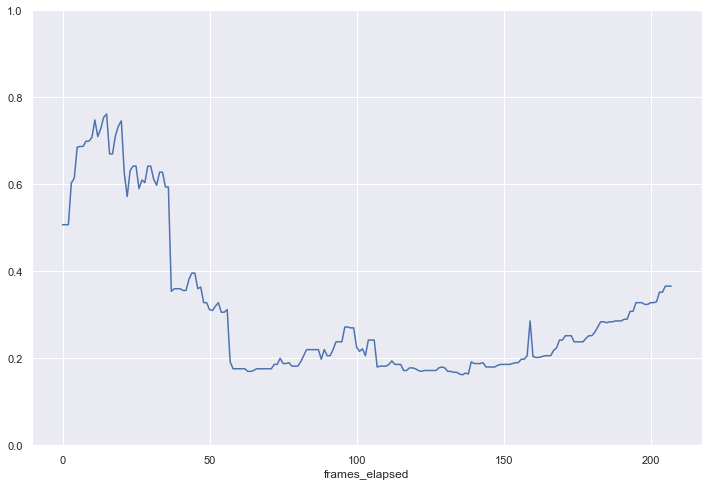

In [115]:
plot_win_probs(mango_axe_game, rf, features)

This is an example of a Mango Axe game, with Axe as player 1. 

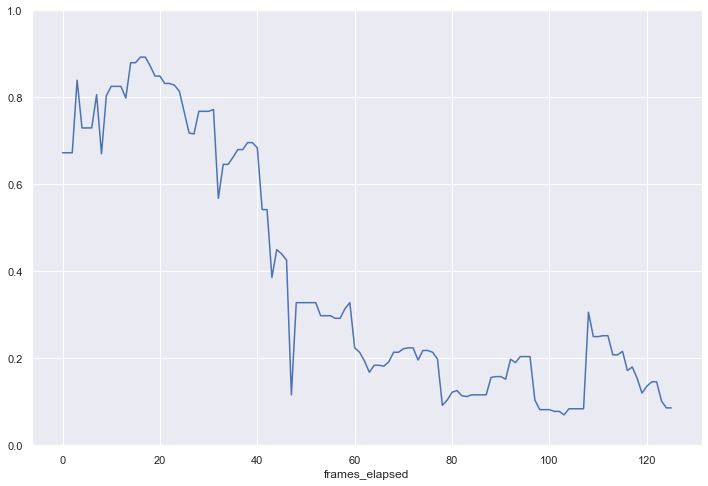

In [116]:
plot_win_probs(mango_zain_game, rf, features)

This is a Zain-Mango game (Zain p1). 

## Checking model priors 

In [54]:
def model_prior(char1, char2, stage,model,feature_list):
    char1 = char1.upper()
    char2 = char2.upper()
    stage = stage.upper()
    df = pd.DataFrame(data = {'p1_char': [char1],
                              'p2_char': [char2],
                              'stage': [stage],
                              'frames_elapsed': [0],
                              'p1_stocks': [4],
                              'p2_stocks': [4],
                              'p1_damage': [0],
                              'p2_damage': [0]
    })
    df = ohe_chars_stage(df)
    return model.predict_proba(df[feature_list])[0][1]
    

In [55]:
@interact
def initial_odds(Character_1 = characters, Character_2 = characters, stage = stages):
    p1_odds = model_prior(Character_1, Character_2, stage,rf,features)
    print('Odds of player 1 winning: {:.3f}'.format(p1_odds))

interactive(children=(Dropdown(description='Character_1', options=('FOX', 'FALCO', 'MARTH', 'SHEIK', 'JIGGLYPU…

In [56]:
def plot_matchup_heatmap(num_chars, stage, model, features=features, chars = characters):
    hm = np.zeros((num_chars,num_chars))
    for i in range(num_chars):
        for j in range(num_chars):
            hm[i,j] = model_prior(chars[i], chars[j], stage,model,features)
    plt.figure(figsize=(7,6))
    sns.heatmap(data = hm, cmap='rocket',annot=True,xticklabels=chars[:num_chars],yticklabels=chars[:num_chars])
    plt.ylabel('Player 1')
    plt.xlabel('Player 2')
    plt.title('Chances of Player 1 winning on '+ stage)
    plt.show()

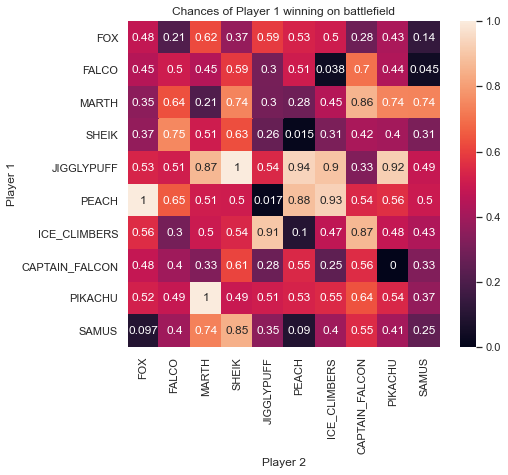

In [57]:
plot_matchup_heatmap(10,'battlefield',rf)

Definitely some weird stuff here. None of these odds should be at 0, and the diagonals should theoretically be even. I think this might be an issue with the fact that the model doesn't understand that it doesnt matter if the player is p1 or p2. There are a couple of ways I think this could be fixed. Randomly scrambling the p1 and p2 associated columns might work, because that would ensure that an even number of say fox games end up in player 1 or player 2. I'll also try just swapping the columns completely and concatenating the data.

## Scrambling data

In [30]:
def swap_cols(df, random):
    df2 = df.copy()
    np.random.seed(42)
    
    idx = np.array([True]*len(df))
    if random:
        idx = np.random.rand(len(df)) < 0.5
    df2['loser'] = 1-df2['winner'] 
    
    # passing numpy array to bypass column alignment
    df2.loc[idx, ['p1_char','p2_char']] = df2.loc[idx, ['p2_char','p1_char']].to_numpy()
    df2.loc[idx, ['p1_stocks','p2_stocks']] = df2.loc[idx, ['p2_stocks','p1_stocks']].to_numpy()
    df2.loc[idx, ['p1_damage','p2_damage']] = df2.loc[idx, ['p2_damage','p1_damage']].to_numpy()
    df2.loc[idx, ['winner','loser']] = df2.loc[idx, ['loser','winner']].to_numpy()
    return df2.drop(columns=['loser'])

In [297]:
df_scrambled_rand = pd.concat([gs_5s_ohe, fp9_5s_ohe])[df.columns[:10]]
df_scrambled_rand=swap_cols(df_scrambled_rand, True)
df_scrambled_rand = df_scrambled_rand[df_scrambled_rand['frames_elapsed']%300==0]
df_scrambled_rand.reset_index(drop=True,inplace=True)
df_scrambled_rand = ohe_chars_stage(df_scrambled_rand)
df_scrambled_rand

,id,p1_char,p2_char,stage,frames_elapsed,p1_stocks,p2_stocks,p1_damage,p2_damage,winner,p1_FOX,p1_FALCO,p1_MARTH,p1_SHEIK,p1_JIGGLYPUFF,p1_PEACH,p1_ICE_CLIMBERS,p1_CAPTAIN_FALCON,p1_PIKACHU,p1_SAMUS,p1_DR_MARIO,p1_YOSHI,p1_LUIGI,p1_GANONDORF,p1_MARIO,p1_YOUNG_LINK,p1_DONKEY_KONG,p1_LINK,p1_GAME_AND_WATCH,p1_ROY,p1_MEWTWO,p1_ZELDA,p1_NESS,p1_PICHU,p1_BOWSER,p1_KIRBY,p2_FOX,p2_FALCO,p2_MARTH,p2_SHEIK,p2_JIGGLYPUFF,p2_PEACH,p2_ICE_CLIMBERS,p2_CAPTAIN_FALCON,p2_PIKACHU,p2_SAMUS,p2_DR_MARIO,p2_YOSHI,p2_LUIGI,p2_GANONDORF,p2_MARIO,p2_YOUNG_LINK,p2_DONKEY_KONG,p2_LINK,p2_GAME_AND_WATCH,p2_ROY,p2_MEWTWO,p2_ZELDA,p2_NESS,p2_PICHU,p2_BOWSER,p2_KIRBY,stage_BATTLEFIELD,stage_FINAL_DESTINATION,stage_DREAM_LAND_N64,stage_YOSHIS_STORY,stage_FOUNTAIN_OF_DREAMS,stage_POKEMON_STADIUM
0,Game_20190309T134133,MARTH,FOX,BATTLEFIELD,0,4.0,4.0,0.000000,0.000000,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,300,4.0,4.0,0.000000,0.000000,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,600,4.0,4.0,27.440001,0.000000,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,900,4.0,4.0,52.270004,0.000000,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,Game_20190309T134133,MARTH,FOX,BATTLEFIELD,1200,4.0,4.0,0.000000,95.940002,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133648,Game_20190406T175301,SHEIK,CAPTAIN_FALCON,FINAL_DESTINATION,10800,1.0,1.0,18.340000,56.620003,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
133649,Game_20190406T175301,CAPTAIN_FALCON,SHEIK,FINAL_DESTINATION,11100,1.0,1.0,56.620003,31.340000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
133650,Game_20190406T175301,CAPTAIN_FALCON,SHEIK,FINAL_DESTINATION,11400,1.0,1.0,84.080009,31.340000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
133651,Game_20190406T175301,SHEIK,CAPTAIN_FALCON,FINAL_DESTINATION,11700,1.0,1.0,31.340000,91.080009,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [298]:
df_train_s, df_test_s = train_test_split(df_scrambled_rand, test_size=0.25, random_state=42)
X_train_s = df_train_s[features]
y_train_s = df_train_s['winner']

X_test_s = df_test_s[features]
y_test_s = df_test_s['winner']

Average accuracy: 0.798
Average log loss: 0.437


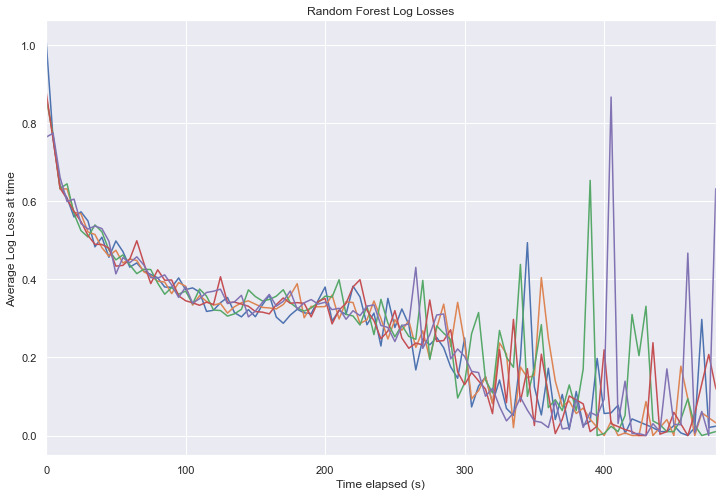

In [299]:
rf_s = CV_model(RandomForestClassifier(n_estimators =100), X_train_s, y_train_s, 'Random Forest Log Losses')

The accuracy and log loss are worse, not what I expected

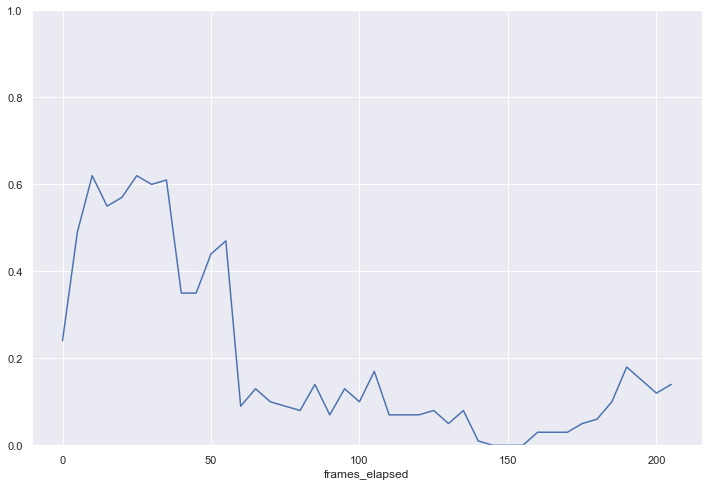

In [300]:
plot_win_probs(mango_axe_game, rf_s, features)

The beginning win probability for Axe is different now, but its still lower than it maybe should be

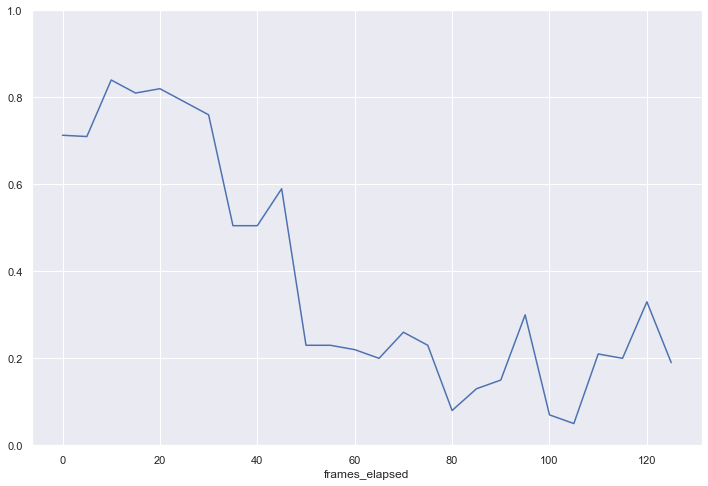

In [301]:
plot_win_probs(mango_zain_game, rf_s, features)

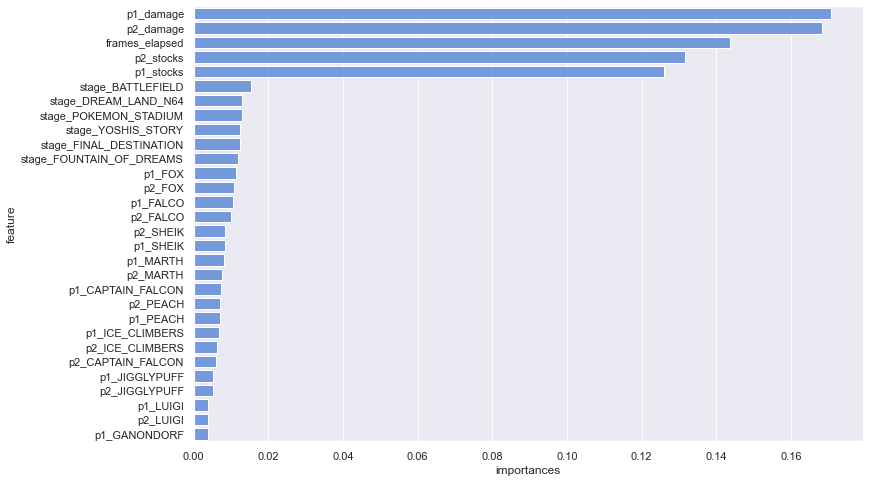

In [302]:
plot_feature_importances(rf_s, features,30)

Interestingly, the scrambled data's feature importances lineup better with what I expect. Now its damage, time, stocks, all stages together, then the top tiers, mostly grouped together p1/p2

## Flipping and adding data

In [31]:
df_swapped = pd.concat([gs_5s_ohe, fp9_5s_ohe])[df.columns[:10]]
df_swapped=swap_cols(df_swapped, False)
df_swapped = df_swapped[df_swapped['frames_elapsed']%300==0]
df_swapped.reset_index(drop=True,inplace=True)
df_swapped = ohe_chars_stage(df_swapped)

df_combined = pd.concat([df,df_swapped]).reset_index(drop=True)
df_combined

,id,p1_char,p2_char,stage,frames_elapsed,p1_stocks,p2_stocks,p1_damage,p2_damage,winner,p1_FOX,p1_FALCO,p1_MARTH,p1_SHEIK,p1_JIGGLYPUFF,p1_PEACH,p1_ICE_CLIMBERS,p1_CAPTAIN_FALCON,p1_PIKACHU,p1_SAMUS,p1_DR_MARIO,p1_YOSHI,p1_LUIGI,p1_GANONDORF,p1_MARIO,p1_YOUNG_LINK,p1_DONKEY_KONG,p1_LINK,p1_GAME_AND_WATCH,p1_ROY,p1_MEWTWO,p1_ZELDA,p1_NESS,p1_PICHU,p1_BOWSER,p1_KIRBY,p2_FOX,p2_FALCO,p2_MARTH,p2_SHEIK,p2_JIGGLYPUFF,p2_PEACH,p2_ICE_CLIMBERS,p2_CAPTAIN_FALCON,p2_PIKACHU,p2_SAMUS,p2_DR_MARIO,p2_YOSHI,p2_LUIGI,p2_GANONDORF,p2_MARIO,p2_YOUNG_LINK,p2_DONKEY_KONG,p2_LINK,p2_GAME_AND_WATCH,p2_ROY,p2_MEWTWO,p2_ZELDA,p2_NESS,p2_PICHU,p2_BOWSER,p2_KIRBY,stage_BATTLEFIELD,stage_FINAL_DESTINATION,stage_DREAM_LAND_N64,stage_YOSHIS_STORY,stage_FOUNTAIN_OF_DREAMS,stage_POKEMON_STADIUM
0,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,0,4.0,4.0,0.000000,0.00,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,300,4.0,4.0,0.000000,0.00,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,600,4.0,4.0,27.440001,0.00,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,900,4.0,4.0,52.270004,0.00,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,1200,4.0,4.0,95.940002,0.00,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559024,Game_20190406T175301,CAPTAIN_FALCON,SHEIK,FINAL_DESTINATION,10800,1.0,1.0,56.620003,18.34,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
559025,Game_20190406T175301,CAPTAIN_FALCON,SHEIK,FINAL_DESTINATION,11100,1.0,1.0,56.620003,31.34,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
559026,Game_20190406T175301,CAPTAIN_FALCON,SHEIK,FINAL_DESTINATION,11400,1.0,1.0,84.080009,31.34,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
559027,Game_20190406T175301,CAPTAIN_FALCON,SHEIK,FINAL_DESTINATION,11700,1.0,1.0,91.080009,31.34,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [32]:
df_train_c, df_test_c = train_test_split(df_combined, test_size=0.25, random_state=42)
df_val_c, df_test_c = train_test_split(df_train_c, test_size=0.2, random_state=42)

X_train_c = df_train_c[features]
y_train_c = df_train_c['winner']

X_val_c = df_val_c[features]
y_val_c = df_val_c['winner']

X_test_c = df_test_c[features]
y_test_c = df_test_c['winner']

Average training accuracy: 0.985
Average training log loss: 0.133
Average CV accuracy: 0.795
Average CV log loss: 0.435


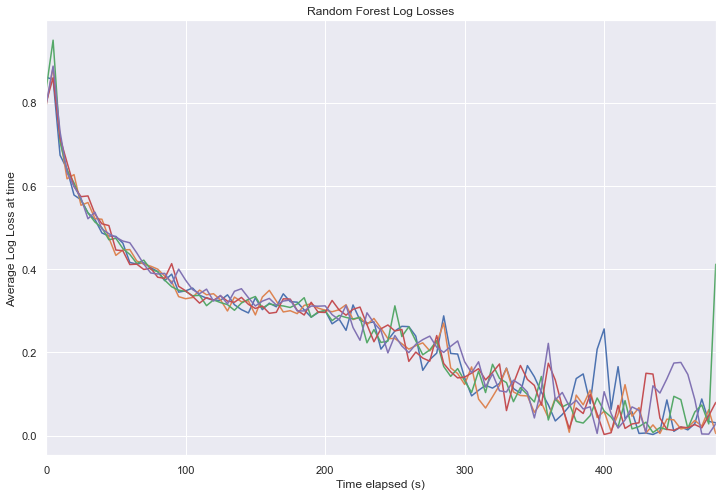

In [33]:
rf_c = CV_model(RandomForestClassifier(n_estimators =100,n_jobs=-1), X_train_c, y_train_c, 'Random Forest Log Losses')

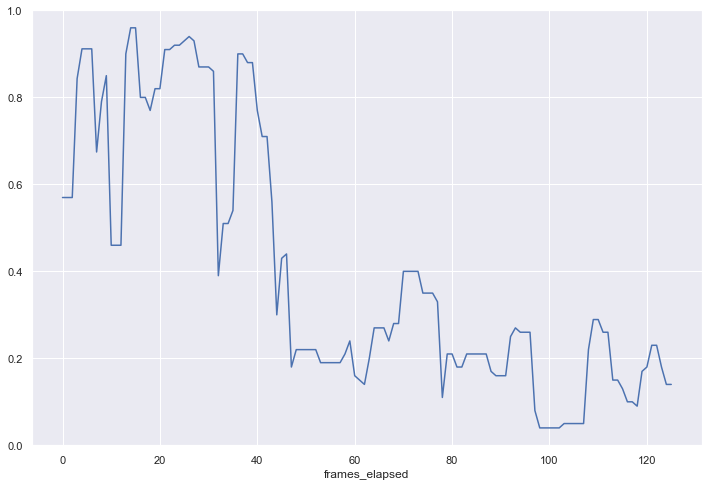

In [34]:
plot_win_probs(mango_zain_game, rf_c, features)

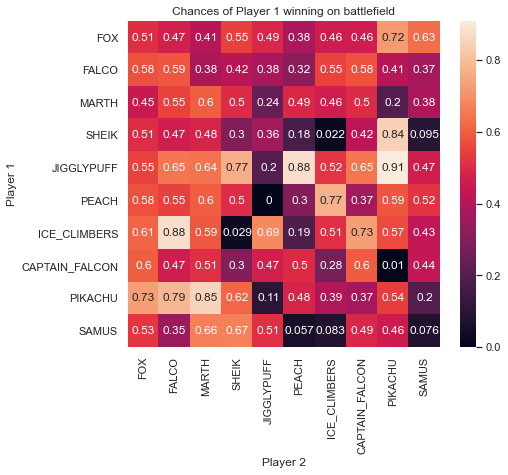

In [39]:
plot_matchup_heatmap(10,'battlefield',rf_c)

In [231]:
@interact
def initial_odds(Character_1 = characters, Character_2 = characters, stage = stages):
    p1_odds = model_prior(Character_1, Character_2, stage,rf_c,features)
    print('Odds of player 1 winning: {:.3f}'.format(p1_odds))

interactive(children=(Dropdown(description='Character_1', options=('FOX', 'FALCO', 'MARTH', 'SHEIK', 'JIGGLYPU…

Still some weird stuff, but as a whole looks a bit better, with the diagonal being closer to 0.5. Not sure if I'll keep doing this kind of processing, but I'll keep it in mind.

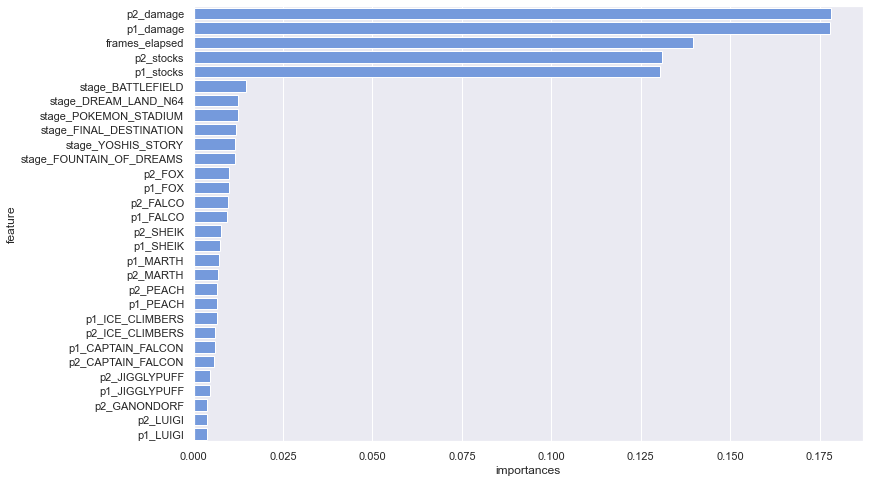

In [310]:
plot_feature_importances(rf_c, features,30)

Feature importances are nicely grouped again, only slightly worse than the scrambled data

## XGBoost

In [248]:
xgb_model = xgb.XGBClassifier(
                        objective='binary:logistic', 
                        use_label_encoder=False, n_jobs = -1
                       )
eval_set = [(X_val, y_val)]

xgb_model.fit(X_train, y_train, eval_set=eval_set,eval_metric='error', early_stopping_rounds=50,verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [249]:
y_pred_prob = xgb_model.predict_proba(X_val_x)
y_pred = xgb_model.predict(X_val_x)

In [250]:
log_loss(y_val_x, y_pred_prob)

0.43159498678253233

In [251]:
accuracy_score(y_val_x, y_pred)

0.7886671987230647

In [18]:
def CV_xgb_model(model, X, y, title = ''):
    val_accuracies = []
    val_avg_loglosses = []
    
    train_accuracies = []
    train_avg_loglosses = []
    kf = KFold(n_splits=3,random_state=41, shuffle=True)
    plt.figure(figsize=(12,8))
    for train_index, val_index in kf.split(X):
        cv_model = clone(model)
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.to_numpy()[train_index], y.to_numpy()[val_index]
        eval_set = [(X_val, y_val)]
        
        cv_model.fit( X_train, y_train, eval_set=eval_set,
                      eval_metric='error', early_stopping_rounds=50,verbose=False)
        y_pred = cv_model.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        val_accuracies.append(acc)

        y_pred_prob = cv_model.predict_proba(X_val)
        ll = log_loss(y_val, y_pred_prob)
        val_avg_loglosses.append(ll)
        
        y_pred_t = cv_model.predict(X_train)
        acc_t = accuracy_score(y_train, y_pred_t)
        train_accuracies.append(acc_t)

        y_pred_prob_t = cv_model.predict_proba(X_train)
        ll_t = log_loss(y_train, y_pred_prob_t)
        train_avg_loglosses.append(ll_t)


        df = X_val.copy()
        df['log_loss'] = get_log_losses(X_val,y_val, cv_model)
        df = df.groupby(['frames_elapsed'])[['log_loss']].mean().reset_index()
        sns.lineplot(x=df['frames_elapsed']/60, y=df['log_loss'])

    print('Average training accuracy: {:.3f}'.format(np.mean(train_accuracies)))
    print('Average training log loss: {:.3f}'.format(np.mean(train_avg_loglosses)))
    
    print('Average validation accuracy: {:.3f}'.format(np.mean(val_accuracies)))
    print('Average validation log loss: {:.3f}'.format(np.mean(val_avg_loglosses)))
    plt.ylabel('Average Log Loss at time')
    plt.xlabel('Time elapsed (s)')
    plt.xlim((0,480))
    plt.title(title)
    plt.show()

    model.fit(X,y, eval_metric='error')
    return model

Average training accuracy: 0.768
Average training log loss: 0.488
Average validation accuracy: 0.758
Average validation log loss: 0.497


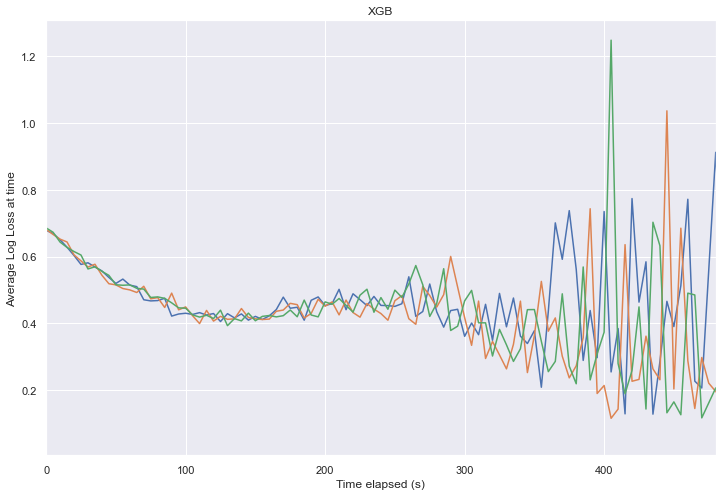

In [342]:
xg_base = xgb.XGBClassifier(n_jobs = -1, 
                        objective='binary:logistic', 
                        use_label_encoder=False
                       )

xg_base=CV_xgb_model(xg, X_train, y_train, 'XGB')

In [344]:
xg_base.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.0500000007,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 10,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.5,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eta': 0.05}

Average training accuracy: 0.868
Average training log loss: 0.320
Average validation accuracy: 0.785
Average validation log loss: 0.431


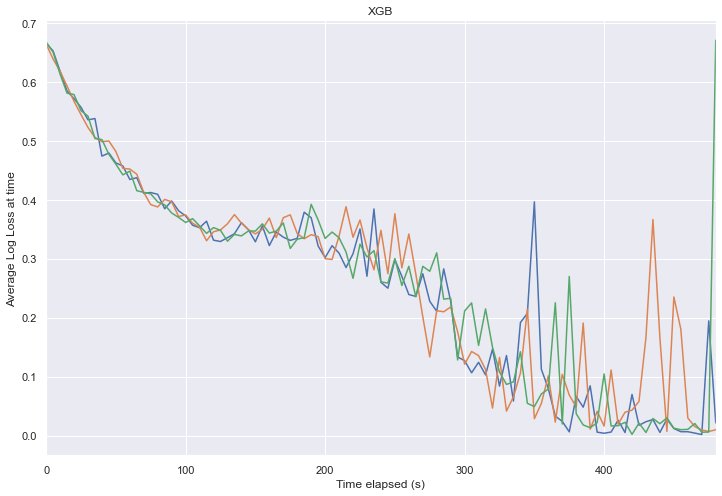

In [20]:
xg = xgb.XGBClassifier(n_jobs = -1, 
                        objective='binary:logistic', 
                        use_label_encoder=False,
                       gamma = .75,
                       n_estimators = 500,
                       reg_alpha=0.5,
                       reg_lambda = 2,
                       max_depth=10,
                       eta = .15
                       )

xg=CV_xgb_model(xg, X_train, y_train, 'XGB')

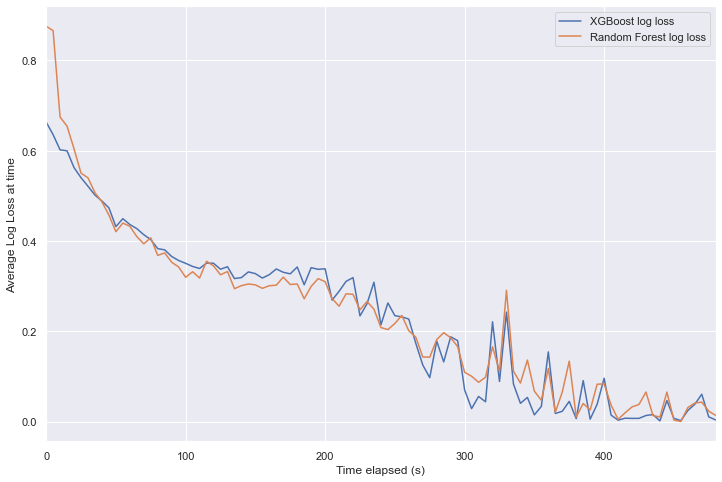

In [21]:
plot_multiple_log_loss(X_val, y_val, [xg,rf], ['XGBoost','Random Forest'])

In [23]:
with open('saved_data/xgb_model.pkl', 'wb') as f:
    pickle.dump(xg, f)

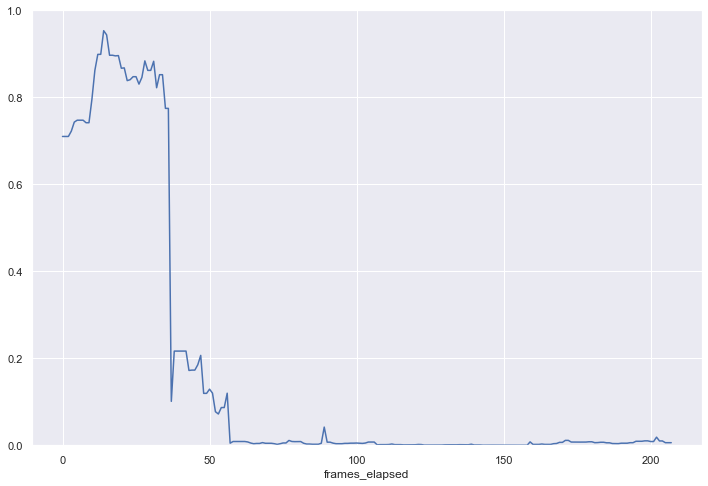

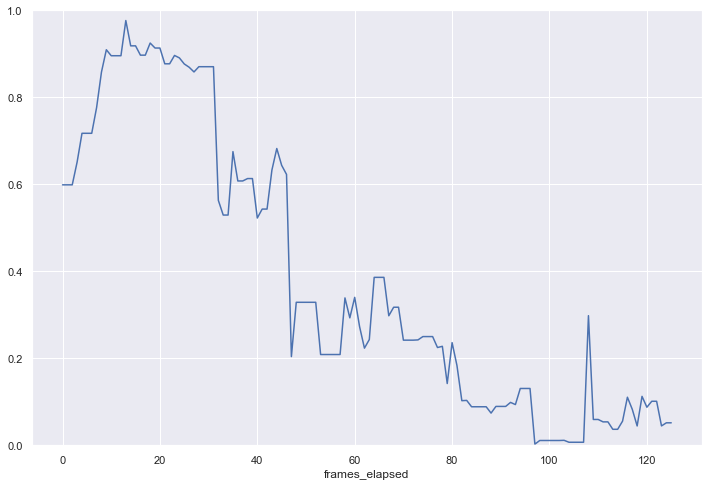

In [27]:
plot_win_probs(mango_axe_game, xg, features)
plot_win_probs(mango_zain_game, xg, features)